In [1]:
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import keras_tuner as kt
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
with open(r'.\News_Dataset_Splits\X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open(r'.\News_Dataset_Splits\X_val.pkl', 'rb') as f:
    X_val = pickle.load(f)

with open(r'.\News_Dataset_Splits\X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open(r'.\News_Dataset_Splits\y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open(r'.\News_Dataset_Splits\y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)

with open(r'.\News_Dataset_Splits\y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

encoder = LabelEncoder()
encoder.fit(np.unique(y_train))
train_labels = encoder.transform(y_train)
val_labels = encoder.transform(y_val)
test_labels = encoder.transform(y_test)
num_classes = len(encoder.classes_)
train_one_hot = keras.utils.to_categorical(train_labels, num_classes=num_classes)
val_one_hot = keras.utils.to_categorical(val_labels, num_classes=num_classes)
test_one_hot = keras.utils.to_categorical(test_labels, num_classes=num_classes)

with open(r'.\embeddingMatrix_News.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)

num_tokens = len(embedding_matrix) # total vocabulary +1 or length of embedding matrix
embedding_dim = 300 # dimension of the vector of a single word
MAX_NEWS_LEN = 500 # maximum words in a review

In [3]:
embedding_layer = keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_NEWS_LEN,
    trainable=True,
    mask_zero=True)

model = keras.Sequential()
model.add(embedding_layer)

activation = 'tanh'
kernel_initializer = 'glorot_uniform'

model.add(layers.LSTM(128, activation=activation, kernel_initializer=kernel_initializer, return_sequences=True))

model.add(layers.LSTM(128, activation=activation, kernel_initializer=kernel_initializer, return_sequences=False))
model.add(layers.BatchNormalization())

model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [4]:
NUM_EPOCHS = 3
BATCH_SIZE = 128
history = model.fit(X_train, train_one_hot, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, val_one_hot))

Epoch 1/3
1488/1488 [==============================] - 154s 98ms/step - loss: 0.9010 - accuracy: 0.7389 - val_loss: 0.7245 - val_accuracy: 0.7988
Epoch 2/3
1488/1488 [==============================] - 144s 96ms/step - loss: 0.5297 - accuracy: 0.8439 - val_loss: 0.5011 - val_accuracy: 0.8489
Epoch 3/3
1488/1488 [==============================] - 142s 96ms/step - loss: 0.3726 - accuracy: 0.8850 - val_loss: 0.5132 - val_accuracy: 0.8382


In [5]:
score = model.evaluate(X_val, val_one_hot, verbose=1)
print("Validation loss: ", score[0])
print("Validation accuracy: ", score[1])

1488/1488 [==============================] - 34s 23ms/step - loss: 0.5132 - accuracy: 0.8382
Validation loss:  0.5132242441177368
Validation accuracy:  0.8381932973861694


In [6]:
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_actuals = np.argmax(test_one_hot, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_actuals, y_prediction , normalize='pred')
print(result)

1313/1313 [==============================] - 32s 23ms/step
[[0.84936351 0.01184394 0.01760412 0.00549163 0.01082707 0.04254975
  0.00960219 0.00435897 0.00342556 0.02958293]
 [0.01438001 0.85322805 0.0193216  0.00627615 0.01443609 0.02248827
  0.02798354 0.02769231 0.00632411 0.00387973]
 [0.01603017 0.01207617 0.77801632 0.00706067 0.01233083 0.03834331
  0.01563786 0.00282051 0.00447958 0.0099418 ]
 [0.0174446  0.01346958 0.02576213 0.88153766 0.05293233 0.03704902
  0.00823045 0.00153846 0.00632411 0.00897187]
 [0.01532296 0.010915   0.05474453 0.0541318  0.84090226 0.12845818
  0.01865569 0.00282051 0.00948617 0.01212415]
 [0.01225837 0.00557362 0.01889223 0.00810669 0.01353383 0.63274551
  0.00356653 0.00128205 0.00527009 0.00848691]
 [0.02310231 0.04203437 0.03885788 0.01019874 0.01744361 0.02879793
  0.88916324 0.00512821 0.01370224 0.00557711]
 [0.00801509 0.03228054 0.0137398  0.00862971 0.00421053 0.00873645
  0.01481481 0.95128205 0.00632411 0.00363725]
 [0.02758133 0.007199

In [7]:
accuracy_score = metrics.accuracy_score(y_prediction, y_actuals)

print('RNN accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_actuals, y_prediction)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_actuals, y_prediction))

RNN accuracy is 83.74%
------------------------------------------------
Confusion Matrix:
      0     1     2     3     4     5     6     7     8     9
0  3603    51    82    21    36   263    35    17    13   122
1    61  3674    90    24    48   139   102   108    24    16
2    68    52  3624    27    41   237    57    11    17    41
3    74    58   120  3371   176   229    30     6    24    37
4    65    47   255   207  2796   794    68    11    36    50
5    52    24    88    31    45  3911    13     5    20    35
6    98   181   181    39    58   178  3241    20    52    23
7    34   139    64    33    14    54    54  3710    24    15
8   117    31    47    32    58   257    27     7  3544    88
9    70    49   107    39    53   119    18     5    41  3697
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4243
           1       0.85      0.86      0.86    

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

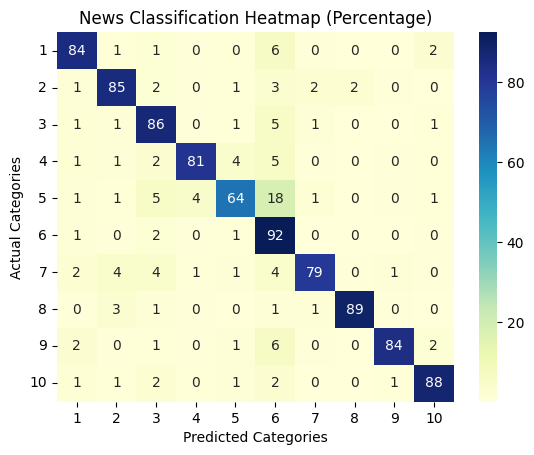

In [9]:
# Create a confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes))
for i in range(len(y_prediction)):
    confusion_matrix[y_actuals[i], y_prediction[i]] += 1

# Normalize the confusion matrix to show percentages
confusion_matrix = 100 * confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

lables = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Create a heatmap with annotation
annot_matrix = np.around(confusion_matrix, 1).astype(int)  # Round percentages to 1 decimal place
ax = sns.heatmap(confusion_matrix, annot=annot_matrix, fmt='d', cmap="YlGnBu", xticklabels=lables, yticklabels=lables)

# Set the title and axis labels
plt.title("News Classification Heatmap (Percentage)")
plt.xlabel("Predicted Categories")
plt.ylabel("Actual Categories")

# Rotate the x-axis labels for better visibility
plt.yticks(rotation=0)

# Display the heatmap
plt.show()

In [10]:
from tensorflow.keras.models import load_model
import os

# Save the model
model_save_path = 'SavedModels/RNN_BestModel.h5'
model.save(model_save_path)

In [11]:
# Load the model
loaded_model = load_model(model_save_path)
score2 = loaded_model.evaluate(X_val, val_one_hot, verbose=1)
print("Validation loss: ", score2[0])
print("Validation accuracy: ", score2[1])

1488/1488 [==============================] - 37s 24ms/step - loss: 0.5132 - accuracy: 0.8382
Validation loss:  0.5132242441177368
Validation accuracy:  0.8381932973861694
